In [3]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

In [4]:
model = "MOBS_NEU-GLEAM_COVID"
rd=12
predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

loclist = list(predictions.location.unique())
loclist.remove('US')

In [5]:
rd = 12
start_week = Week(2022,2)
end_week = Week(2022,13)
max_date = None
#max_date = datetime.datetime(2022, 3, 15)
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","NotreDame-FRED","UNCC-hierbin","USC-SIkJalpha",
           "UTA-ImmunoSEIRS","UVA-EpiHiper","UVA-adaptive"]

In [112]:

modelmap = {'Ensemble':r'Ensemble_vincent$^2$', "Ensemble_LOP":r"Ensemble_LOP$^2$","Ensemble_LOP_untrimmed":r"Ensemble_LOP_untrimmed$^2$",
            "JHU_IDD-CovidSP":'A', "MOBS_NEU-GLEAM_COVID":'B', "UNCC-hierbin":'C', "USC-SIkJalpha":'D', 
            "UVA-EpiHiper":'E', "UVA-adaptive":'F', 'CU-AGE-ST':'G', 'JHUAPL-Bucky':'H', 'Karlen-pypm':'I',
            "NCSU-COVSIM":'J', "NotreDame-FRED":'K', "UTA-ImmunoSEIRS":'L' }

# Coverage table averaged over locations

In [101]:
df_hosp_wisnorm= pd.read_pickle('df_wisnorm_hosp_414.pkl')
df_death_wisnorm = pd.read_pickle('df_wisnorm_death_414.pkl')
df_case_wisnorm = pd.read_pickle('df_wisnorm_case_414.pkl')

In [106]:
df_hosp_mape = pd.read_pickle('mapedf_hosp.pkl')
df_death_mape = pd.read_pickle('mapedf_death.pkl')
df_case_mape = pd.read_pickle('mapedf_case.pkl')

In [104]:
df = pd.read_pickle('WISagg_stdev.pkl')
df

,Model,Location,WISscaled,Target,Round
0,CU-AGE-ST,Alabama,0.691311,hosp,5
1,Ensemble_LOP,Alabama,0.703623,hosp,5
2,Ensemble,Alabama,0.506634,hosp,5
3,JHU_IDD-CovidSP,Alabama,2.843615,hosp,5
4,Karlen-pypm,Alabama,1.296194,hosp,5
...,...,...,...,...,...
14377,JHU_IDD-CovidSP,Wyoming,1.743816,case,16
14378,MOBS_NEU-GLEAM_COVID,Wyoming,1.403092,case,16
14379,USC-SIkJalpha,Wyoming,1.758941,case,16
14380,UVA-adaptive,Wyoming,1.940085,case,16


In [116]:
df = pd.concat([df_hosp_wisnorm, df_death_wisnorm, df_case_wisnorm])
wisdf = pd.read_pickle('WISagg_stdev.pkl')
wisdf = wisdf[wisdf.Round == 12]
mapedf = pd.concat([df_hosp_mape, df_death_mape, df_case_mape])
#models = list(df.Model.unique())
models = ['Ensemble','Ensemble_LOP','Ensemble_LOP_untrimmed','JHU_IDD-CovidSP','MOBS_NEU-GLEAM_COVID','UNCC-hierbin',
 'USC-SIkJalpha','UVA-EpiHiper','UVA-adaptive']
avgscoresdf = pd.DataFrame(columns=['Model', 'WIS','MAPE','50% Coverage','95% Coverage'])


for model in models:
    
    testdf = df[df.Model == model]
    #testdf['normWIS'] = testdf['WIS']/testdf['Population']
    medWIS = wisdf[wisdf.Model == model].WISscaled.median()
    q75wis, q25wis = np.percentile(wisdf[wisdf.Model == model]['WISscaled'], [75 ,25])
    
    avgcov50 = testdf['50% Coverage'].mean()
    q75cov50, q25cov50 = np.percentile(testdf['50% Coverage'], [75 ,25])
    
    
    avgcov95 = testdf['95% Coverage'].mean()
    #q75cov95, q25cov95 = np.percentile(testdf['95% Coverage'], [75 ,25])
    
    mapemed = mapedf[mapedf.Model == model].MAPE.median()
    q75mape, q25mape = np.percentile(mapedf[mapedf.Model == model]['MAPE'], [75 ,25])

    
    new_row = {'Model':modelmap[model], 'WIS':str(round(medWIS,3)) + ' '+str((round(q25wis,2), round(q75wis,2))) ,
               'MAPE':str(round(mapemed,3)) + ' '+ str((round(q25mape,2), round(q75mape,2))) , 
               '50% Coverage':avgcov50,
               '95% Coverage':avgcov95 }

    avgscoresdf = avgscoresdf.append(new_row, ignore_index=True)
    

In [117]:
avgscoresdf.style.set_caption("Round 12, average scores over all locations")


,Model,WIS,MAPE,50% Coverage,95% Coverage
0,Ensemble_vincent$^2$,"0.552 (0.34, 0.98)","0.568 (0.41, 0.93)",0.355664,0.742375
1,Ensemble_LOP$^2$,"0.534 (0.39, 0.86)","0.552 (0.39, 0.83)",0.597495,0.940632
2,Ensemble_LOP_untrimmed$^2$,"0.639 (0.5, 0.84)","0.551 (0.4, 0.83)",0.763072,0.991285
3,A,"0.691 (0.41, 1.16)","0.662 (0.53, 0.9)",0.427015,0.854575
4,B,"1.023 (0.56, 1.51)","0.83 (0.74, 0.89)",0.184096,0.460784
5,C,"1.243 (0.76, 1.85)","0.755 (0.55, 2.65)",0.078976,0.188998
6,D,"2.075 (1.57, 2.54)","2.527 (1.71, 3.75)",0.122549,0.306100
7,E,"1.697 (1.07, 2.16)","1.909 (0.88, 4.74)",0.160675,0.441721
8,F,"1.362 (0.95, 1.91)","0.941 (0.87, 1.16)",0.120370,0.309913


In [118]:
print(avgscoresdf.round(3).to_latex(index=False))

\begin{tabular}{lllrr}
\toprule
                     Model &                WIS &               MAPE &  50\% Coverage &  95\% Coverage \\
\midrule
      Ensemble\_vincent\$\textasciicircum 2\$ & 0.552 (0.34, 0.98) & 0.568 (0.41, 0.93) &         0.356 &         0.742 \\
          Ensemble\_LOP\$\textasciicircum 2\$ & 0.534 (0.39, 0.86) & 0.552 (0.39, 0.83) &         0.597 &         0.941 \\
Ensemble\_LOP\_untrimmed\$\textasciicircum 2\$ &  0.639 (0.5, 0.84) &  0.551 (0.4, 0.83) &         0.763 &         0.991 \\
                         A & 0.691 (0.41, 1.16) &  0.662 (0.53, 0.9) &         0.427 &         0.855 \\
                         B & 1.023 (0.56, 1.51) &  0.83 (0.74, 0.89) &         0.184 &         0.461 \\
                         C & 1.243 (0.76, 1.85) & 0.755 (0.55, 2.65) &         0.079 &         0.189 \\
                         D & 2.075 (1.57, 2.54) & 2.527 (1.71, 3.75) &         0.123 &         0.306 \\
                         E & 1.697 (1.07, 2.16) & 1.909 (0.88, 4.74

# Coverage plot

In [7]:
df_hosp = pd.read_pickle('df_all_hosp.pkl')
df_death = pd.read_pickle('df_all_death.pkl')
df_case = pd.read_pickle('df_all_case.pkl')

In [12]:
median_ensembles = dict()
extreme_ensembles = dict()

coveragedf = pd.DataFrame(columns=['Model', '10_cov', '20_cov', '30_cov', '40_cov', '50_cov', '60_cov', '70_cov',
                         '80_cov', '90_cov', '95_cov', '98_cov', 'Location', 'Case'])

for l in loclist:
    median_ensembles[l] = {}
    extreme_ensembles[l] = {}
    
    target = 'death'
    #target = 'hosp'
    #target = 'case'
    incidence = True
    target_location = l
    
    
    if target == 'hosp':
        target_obs = 'hospitalization'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]


    
    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    if max_date:
        observations = observations[observations['date'] <= max_date].copy()

    #transform to Observation object
    observations = Observations(observations)
    

    
    

    
    locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
    location_mapping = dict()
    for loc in locations['location']:
        location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]
    
    
    target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,len(observations)+1)]
    
    for model in models:    
        try:
            predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            predictions = predictions[predictions.location != 'US']
            predictions = predictions.astype({'location':'int'})
            
            
            locations = locations[locations.location != 'US']
            locations = locations.astype({'location':'int'})
            
            predictions = predictions.merge(locations, how='inner', on='location')
            
            target_locations = int(target_location)
            
            pred = predictions[predictions['location'] == int(target_location)].copy()
        
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if max_date:
                pred = pred[pred['target_end_date'] <= max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            scenarios = list(pred['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
            med_ensemble_predictions = median_ensemble(predictions_list)
            ex_ensemble_predictions = extreme_ensemble(predictions_list)
            median_ensembles[l][model] = med_ensemble_predictions
            extreme_ensembles[l][model] = ex_ensemble_predictions
            
            predictions_list += [med_ensemble_predictions, ex_ensemble_predictions]
            
            labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ["Median aggregate", "Extreme Aggregate"]

        


            aggregated_scores = dict()
            for label,predictions in zip(labels,predictions_list):
                d,_ = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)
                aggregated_scores[label] = d

            aggregated_data = defaultdict(list)
            
            coverages = ['10_cov', '20_cov', '30_cov', '40_cov', '50_cov', '60_cov', '70_cov',
                         '80_cov', '90_cov', '95_cov', '98_cov']
            for label in ["Median aggregate"]:
                aggregated_data['Case'] += [label]
                
                for cv in coverages:
                
                    aggregated_data[cv] += [aggregated_scores[label][cv]]
                
                agg_data_df = pd.DataFrame(aggregated_data)
                agg_data_df['Model'] = model
                agg_data_df['Location'] = l
                

            
            
            
            
            
            coveragedf = pd.concat([coveragedf, agg_data_df])
            
            
  
        except Exception as e:
            print(e)    
    


There are no predictions for model NCSU-COVSIM at location 01
There are no predictions for model NotreDame-FRED at location 01
There are no predictions for model UTA-ImmunoSEIRS at location 01
There are no predictions for model NCSU-COVSIM at location 02
There are no predictions for model NotreDame-FRED at location 02
There are no predictions for model UTA-ImmunoSEIRS at location 02
There are no predictions for model NCSU-COVSIM at location 04
There are no predictions for model NotreDame-FRED at location 04
There are no predictions for model UTA-ImmunoSEIRS at location 04
There are no predictions for model NCSU-COVSIM at location 05
There are no predictions for model NotreDame-FRED at location 05
There are no predictions for model UTA-ImmunoSEIRS at location 05
There are no predictions for model NCSU-COVSIM at location 06
There are no predictions for model NotreDame-FRED at location 06
There are no predictions for model NCSU-COVSIM at location 08
There are no predictions for model Notr

There are no predictions for model UTA-ImmunoSEIRS at location 49
There are no predictions for model NCSU-COVSIM at location 50
There are no predictions for model NotreDame-FRED at location 50
There are no predictions for model UTA-ImmunoSEIRS at location 50
There are no predictions for model NCSU-COVSIM at location 51
There are no predictions for model NotreDame-FRED at location 51
There are no predictions for model UTA-ImmunoSEIRS at location 51
There are no predictions for model NCSU-COVSIM at location 53
There are no predictions for model NotreDame-FRED at location 53
There are no predictions for model UTA-ImmunoSEIRS at location 53
There are no predictions for model NCSU-COVSIM at location 54
There are no predictions for model NotreDame-FRED at location 54
There are no predictions for model UTA-ImmunoSEIRS at location 54
There are no predictions for model NCSU-COVSIM at location 55
There are no predictions for model NotreDame-FRED at location 55
There are no predictions for model 

In [8]:
coverages = ['10_cov', '20_cov', '30_cov', '40_cov', '50_cov', '60_cov', '70_cov', '80_cov', '90_cov', '95_cov', '98_cov']

In [13]:
coveragedf_death = coveragedf

In [120]:
coveragedf_death

,Model,10_cov,20_cov,30_cov,40_cov,50_cov,60_cov,70_cov,80_cov,90_cov,95_cov,98_cov,Location,Case
0,Ensemble,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.166667,0.333333,0.333333,0.333333,01,Median aggregate
0,Ensemble_LOP,0.000000,0.000000,0.000000,0.083333,0.083333,0.083333,0.250000,0.333333,0.583333,0.666667,0.833333,01,Median aggregate
0,Ensemble_LOP_untrimmed,0.000000,0.000000,0.083333,0.083333,0.333333,0.583333,0.583333,0.666667,0.833333,1.000000,1.000000,01,Median aggregate
0,JHU_IDD-CovidSP,0.000000,0.000000,0.000000,0.000000,0.083333,0.083333,0.083333,0.083333,0.250000,0.250000,0.416667,01,Median aggregate
0,MOBS_NEU-GLEAM_COVID,0.000000,0.083333,0.083333,0.166667,0.250000,0.333333,0.416667,0.416667,0.500000,0.583333,0.666667,01,Median aggregate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,MOBS_NEU-GLEAM_COVID,0.250000,0.250000,0.333333,0.333333,0.416667,0.416667,0.500000,0.583333,0.666667,0.750000,0.750000,56,Median aggregate
0,UNCC-hierbin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.083333,0.166667,0.250000,0.250000,56,Median aggregate
0,USC-SIkJalpha,0.083333,0.166667,0.166667,0.166667,0.250000,0.333333,0.416667,0.416667,0.500000,0.500000,0.500000,56,Median aggregate
0,UVA-EpiHiper,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.250000,0.250000,0.583333,0.750000,0.833333,56,Median aggregate


In [96]:
df = pd.concat([coveragedf_death, coveragedf_case, coveragedf_hosp])
#df = coveragedf_hosp.copy()
#models = list(df.Model.unique())
models = ['Ensemble','Ensemble_LOP','Ensemble_LOP_untrimmed','JHU_IDD-CovidSP','MOBS_NEU-GLEAM_COVID','UNCC-hierbin',
 'USC-SIkJalpha','UVA-EpiHiper','UVA-adaptive']
#models = models[0:-2]

avgcov = {}

for model in models:
    testdf = df[df.Model == model]
    avgcov[model] = []
    
    for cv in coverages:
        cov = testdf[cv].mean()
        avgcov[model].append(cov)

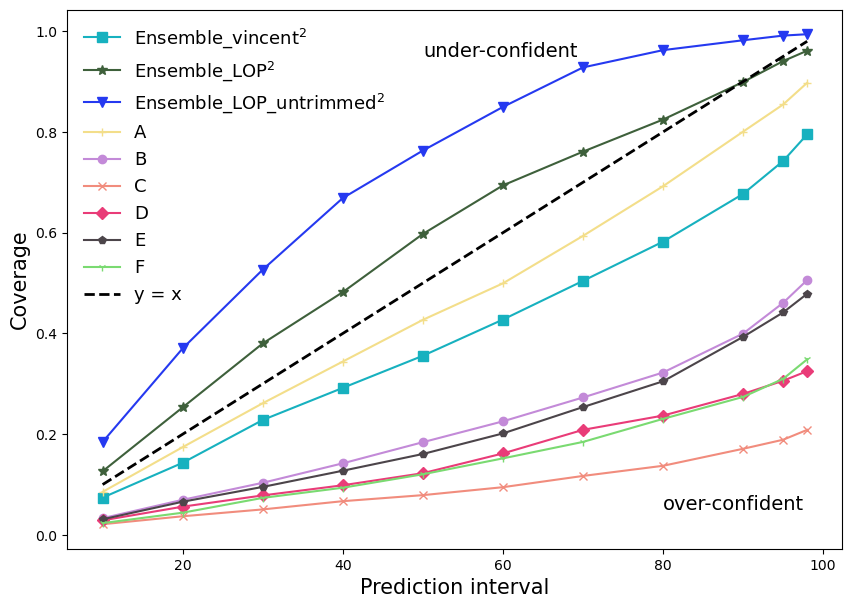

In [104]:
plt.figure(figsize=(10,7))

flatui = ['#17B1BF', '#3E603B', '#2539F0','#F3DE8A', '#C38AD8', '#F18C7D', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9',
         'magenta', 'coral']
marks = ['s', '*', 'v', '+', 'o', 'x', 'D', 'p', '1']

sns.set_palette(flatui)

covers = [10,20,30,40,50,60,70,80,90,95,98]
covsy = [cv/100 for cv in covers]
i=0
for model in models:
    
    if model in ['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed']:
        plt.plot(covers, avgcov[model],marker = marks[i],markersize=7, label=modelmap[model])
    else:
        plt.plot(covers, avgcov[model],marker = marks[i],markersize=6, label=modelmap[model])
    i+=1
plt.plot(covers, covsy, 'k--',label = 'y = x',linewidth=2)  



plt.xlabel('Prediction interval', fontsize=15)
plt.ylabel('Coverage', fontsize=15)
#plt.title('Coverage, all targets and locations, Round 12', fontsize=16)
plt.legend(fontsize=13, frameon=False)
plt.text(80, 0.05, 'over-confident', fontsize=14)
plt.text(50, 0.95, 'under-confident', fontsize=14)
plt.savefig('coverage_allmodels_rd12_515.pdf')
plt.show()


In [111]:
locs = ['06', '48',  '08', '50']
avgcov = {}
for l in locs:
    locdf = df[df['Location'] == l]
    
    locensemblelop = locdf[locdf.Model == 'Ensemble_LOP']
    
    avgcov[l] = []
    
    for cv in coverages:
        cov = locensemblelop[cv].mean()
        avgcov[l].append(cov)

In [112]:
population = []
for l in locs:
    population.append(list(locations[locations.location == int(l)].population)[0])
    
populationsort, locsort = zip(*sorted(zip(population, locs), reverse=True))

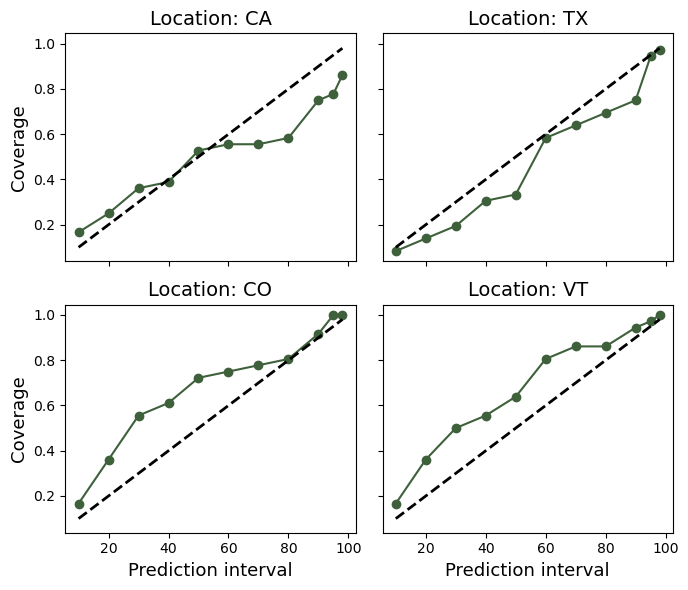

In [116]:
plt.subplots(2,2,figsize=(7,6), sharey=True, sharex=True)
i=1
locsmap = ['6', '48', '8', '50']

for l in locsort:
    title = locsmap[i-1]
    plt.subplot(2,2,i)

    plt.plot(covers, avgcov[l],'-o', color='#3E603B')
    plt.plot(covers, covsy, 'k--',label = 'y = x',linewidth=2) 
    plt.title('Location: ' + location_mapping[title], fontsize=14)
    
    if i in [3,4]:
        plt.xlabel('Prediction interval', fontsize=13)
    
    if i in [1,3]:
        plt.ylabel('Coverage', fontsize=13)
    i+=1
    #plt.ylabel('Mean Coverage', fontsize=14)
    

#plt.suptitle(r'Coverage for all targets, Ensemble_LOP$^2$, round 12 ', fontsize=16)
plt.tight_layout()

#plt.savefig('coverage_ensemblelop2_allrds_515.pdf')

In [130]:
locs = list(df.Location.unique())
avgcov = {}
for l in locs:
    locdf = df[df['Location'] == l]
    
    locensemblelop = locdf[locdf.Model == 'Ensemble_LOP']
    
    avgcov[l] = []
    
    for cv in coverages:
        cov = locensemblelop[cv].mean()
        avgcov[l].append(cov)

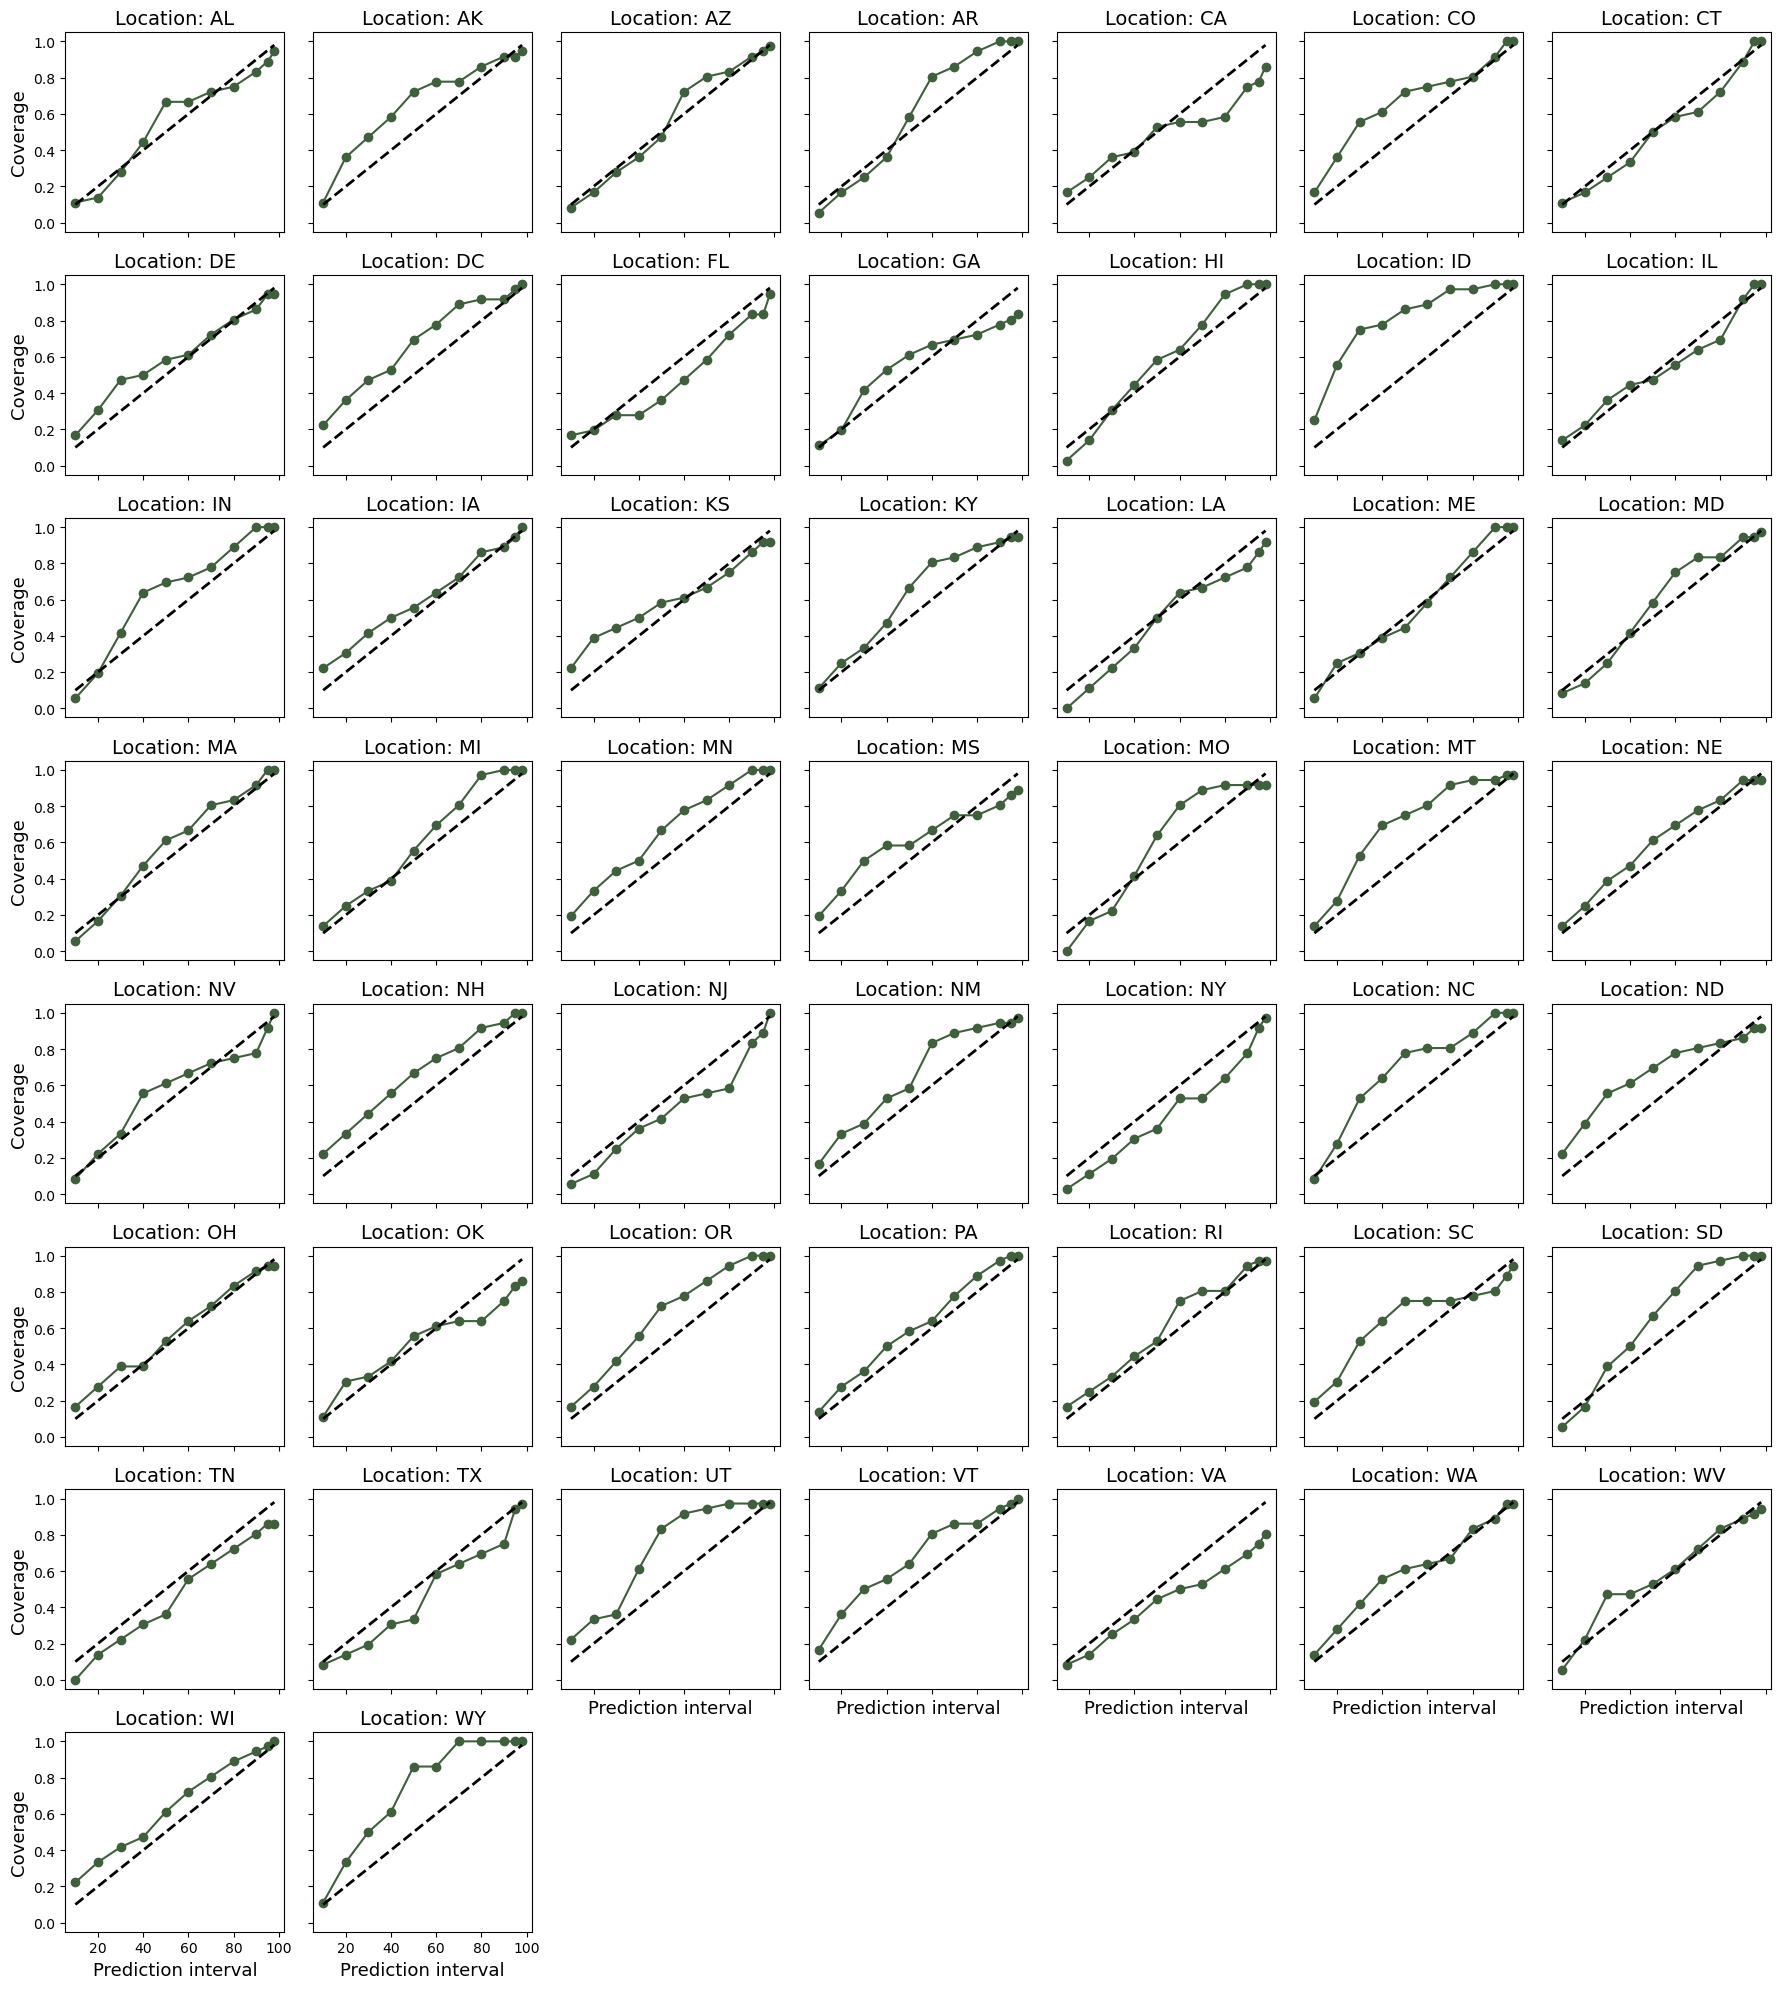

In [138]:
fig,axs = plt.subplots(8,7,figsize=(18,20), sharey=True, sharex=True)
i=1
locsmap = ['1', '2', '4', '5', '6', '8', '9'] + list(df.Location.unique())[7:]

for l in locs:
    title = locsmap[i-1]
    plt.subplot(8,7,i)

    plt.plot(covers, avgcov[l],'-o', color='#3E603B')
    plt.plot(covers, covsy, 'k--',label = 'y = x',linewidth=2) 
    plt.title('Location: ' + location_mapping[title], fontsize=14)
    
    if i in [45,46,47,48,49,50,51]:
        plt.xlabel('Prediction interval', fontsize=13)
    
    if i in [1,8,15, 22, 29, 36,43,50]:
        plt.ylabel('Coverage', fontsize=13)
    i+=1
    #plt.ylabel('Mean Coverage', fontsize=14)
    
fig.delaxes(axs[7,2])
fig.delaxes(axs[7,3])
fig.delaxes(axs[7,4])
fig.delaxes(axs[7,5])
fig.delaxes(axs[7,6])
#plt.suptitle(r'Coverage for all targets, Ensemble_LOP$^2$, round 12 ', fontsize=16)
plt.tight_layout()

plt.savefig('coverage_ensemblelop2_allstates_515.pdf')

plt.show()